In [1]:
import pandas as pd
import numpy as np

In [2]:
bca = pd.read_csv("bca_preprocessed_data.csv", delimiter=',')
bca.head(5)

,content,score,sentiment
0,mohon donk kembalikan tanda biru hitam saat li...,1,0
1,kenapa sekarang untuk transfer ke blu bca ada ...,2,0
2,oke terimakasih,5,2
3,tolong pihak developer untuk update hp saya ga...,5,2
4,ok,5,2


In [3]:
bca.isnull().sum()

content      61
score         0
sentiment     0
dtype: int64

In [4]:
bca = bca.dropna()

In [5]:
bca.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [6]:
bca.shape

(13939, 3)

#### Creating Topic

In [7]:
import gensim
import gensim.corpora as corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk
from collections import defaultdict

#ensure NLTK downloaded
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
bca = bca.dropna(subset=["content"])

#### Preprocess words

In [9]:
stop_words_indo = set(stopwords.words("indonesian"))
stop_words_en = set(stopwords.words("english"))
custom_stopwords = {"nya", "yg", "gak", "ga", "sih", "dong", "deh", "nih", "aja", "bgt","saya", "dan","sdh","sudah"
                    ,"sy","lg","tdk", "udah","lagi"}

stop_words = stop_words_indo.union(stop_words_en, custom_stopwords)

def preprocess_text(text):
    text = text.lower() #c onvert to lowercase
    text = re.sub(r'\d+', '',text) # remove numbers
    text = re.sub(r'[^\w\s]','',text) # remove special characters
    text = re.sub(r'(.)\1+', r'\1\1', text) #limit repeating characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

bca["processedwords"] = bca["content"].apply(preprocess_text)

dictionary = corpora.Dictionary(bca["processedwords"])
corpus = [dictionary.doc2bow(text)for text in bca["processedwords"]]

len(dictionary), corpus[:5]


(12683,
 [[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
  [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
  [(14, 1), (15, 1)],
  [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
  [(21, 1)]])

#### Applying LDA(Latent Dirichlet Allocation)

In [10]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=5,
                                   random_state=42,
                                   passes=10)

topics = lda_model.print_topics(num_words=10)
topics

[(0,
  '0.029*"bagus" + 0.024*"transaksi" + 0.016*"membantu" + 0.016*"bca" + 0.015*"aplikasi" + 0.014*"mudah" + 0.013*"merah" + 0.012*"error" + 0.011*"jaringan" + 0.010*"internet"'),
 (1,
  '0.081*"update" + 0.051*"force" + 0.051*"close" + 0.041*"aplikasi" + 0.025*"buka" + 0.025*"dibuka" + 0.023*"tolong" + 0.021*"bca" + 0.020*"versi" + 0.016*"terbaru"'),
 (2,
  '0.025*"bca" + 0.017*"masuk" + 0.016*"aplikasi" + 0.015*"saldo" + 0.014*"good" + 0.010*"ya" + 0.009*"transaksi" + 0.009*"transfer" + 0.008*"fitur" + 0.008*"cek"'),
 (3,
  '0.050*"app" + 0.015*"update" + 0.012*"apps" + 0.011*"cant" + 0.011*"bca" + 0.010*"accessibility" + 0.010*"use" + 0.010*"please" + 0.010*"fix" + 0.010*"android"'),
 (4,
  '0.043*"verifikasi" + 0.035*"bca" + 0.027*"gagal" + 0.016*"wajah" + 0.014*"bank" + 0.012*"hp" + 0.012*"ulang" + 0.012*"pulsa" + 0.011*"crash" + 0.011*"sms"')]

#### Visualize Topic Distribution

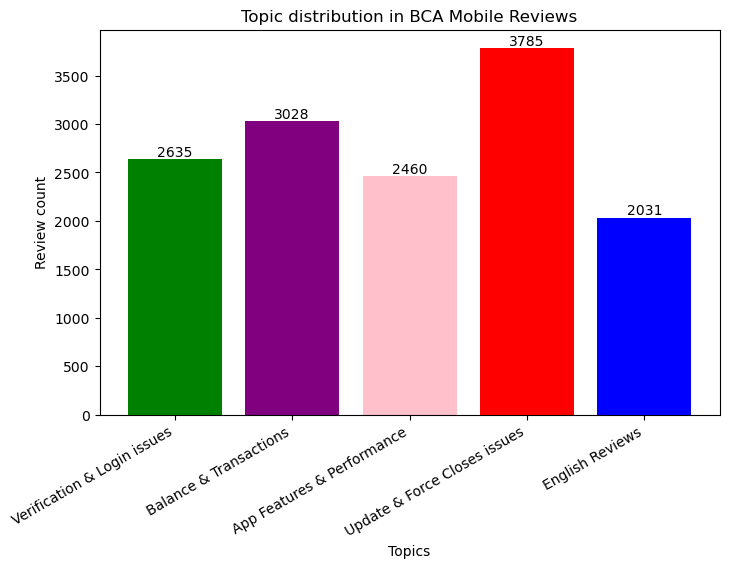

In [11]:
import matplotlib.pyplot as plt

# LDA results 
topic_counts = lda_model.get_document_topics(corpus, minimum_probability=0)
topic_distributions = [0] * 5

# predefined toppings to aligned the LDA results
topic_mapping = {
    0: 2,  # Topic 0 -> "App Features & Performance"
    1: 3,  # Topic 1 -> "Update & Force Closes issues"
    2: 1,  # Topic 2 -> "Balance & Transactions"
    3: 4,  # Topic 3 -> "English Reviews"
    4: 0   # Topic 4 -> "Verification & Login issues"
} 

for doc in topic_counts:
    main_topic = max(doc, key=lambda x: x[1])[0] #get most relevant topic
    mapped_topic = topic_mapping[main_topic] #map predefined labels
    topic_distributions[mapped_topic] += 1

# for doc in topic_counts:
#     main_topic = max(doc, key=lambda x: x[1])[0] #get most relevant topic
#     mapped_topic = topic_mapping[main_topic]
#     topic_distributions[main_topic] += 1

topic_labels =[
    "Verification & Login issues",
    "Balance & Transactions",
    "App Features & Performance",
    "Update & Force Closes issues",
    "English Reviews"
]

#plot bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(topic_labels, topic_distributions, color=["green","purple","pink","red","blue"])
plt.title("Topic distribution in BCA Mobile Reviews")
plt.xlabel("Topics")
plt.ylabel("Review count")
plt.xticks(rotation=30, ha="right") #make xlabel rotate to not overlap

# Add labels on each bar category
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.show()

#### Visualize Sentiment Distribution per topic 2

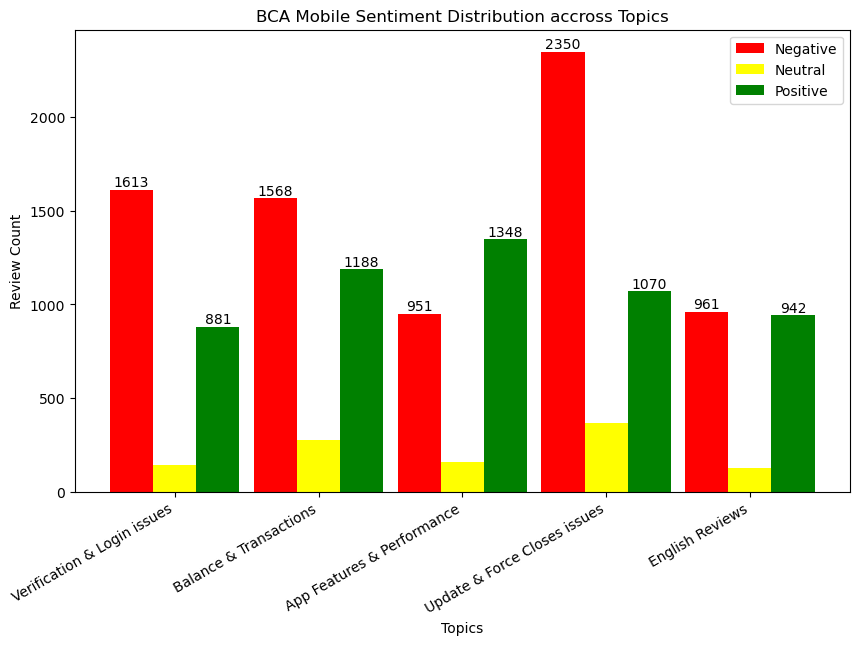

In [12]:
sentiment_per_topic = np.zeros((5,3)) # 5 topics array , 3 sentiment categories

# predefined toppings to aligned the LDA results
topic_mapping = {
    0: 2,  # Topic 0 -> "App Features & Performance"
    1: 3,  # Topic 1 -> "Update & Force Closes issues"
    2: 1,  # Topic 2 -> "Balance & Transactions"
    3: 4,  # Topic 3 -> "English Reviews"
    4: 0   # Topic 4 -> "Verification & Login issues"
} 

# count sentiment per topic
for i, doc in enumerate(topic_counts):
    if i < len(bca):
        main_topic = max(doc, key=lambda x: x[1])[0] # Get most relevant topic
        mapped_topic = topic_mapping[main_topic] # Map to predefined label
        sentiment = int(bca.iloc[i]["sentiment"])
        sentiment_per_topic[mapped_topic][sentiment] +=1

# for i, doc in enumerate(topic_counts):
#     if i < len(bca):
#         main_topic = max(doc, key=lambda x: x[1])[0]
#         sentiment = int(bca.iloc[i]["sentiment"])
#         sentiment_per_topic[main_topic][sentiment] +=1 

# plot sentiment labels and colors
sentiment_labels = ["Negative","Neutral","Positive"]
colors = ["red","yellow","green"]

# plot sentiment breakdown per topic
fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.3

#plot bars for each sentiment
bars = []
for i in range(3):
    bars.append(ax.bar(
        np.arange(5) + i * bar_width,  # Added a comma here, and position bars
        sentiment_per_topic[:, i],
        bar_width,
        label=sentiment_labels[i],
        color=colors[i]
    ))

ax.set_xlabel("Topics")
ax.set_ylabel("Review Count")
ax.set_title("BCA Mobile Sentiment Distribution accross Topics")
ax.set_xticks(np.arange(5)+ bar_width)
ax.set_xticklabels(topic_labels, rotation=30,ha="right")
ax.legend()

# add labels on top of each negative and positive bars
for i in range(5):
    for j in [0,2]: # 0: negative 2: positive
        bar = bars[j][i]
        yval = bar.get_height()
        ax.text(bar.get_x()+ bar.get_width() / 2, yval + 1, int(yval), ha='center', va='bottom')

plt.show()

#### Visualize through WordCloud Positive, Neutral and Negative

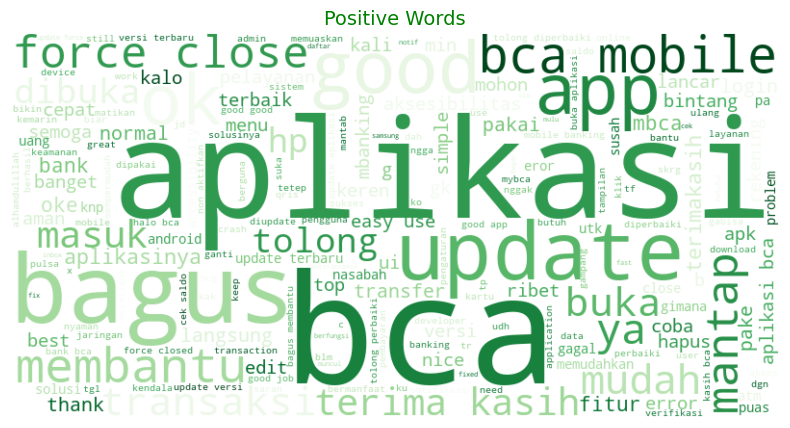

In [30]:
from wordcloud import WordCloud

Positive_text = " ".join(bca[bca["sentiment"]== 2]["processedwords"].dropna().apply(lambda x:" ".join(x)))

wordcloud_positives = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(Positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_positives, interpolation="bilinear")
plt.title("Positive Words", fontsize=14, color="green")
plt.axis("off")
plt.show()

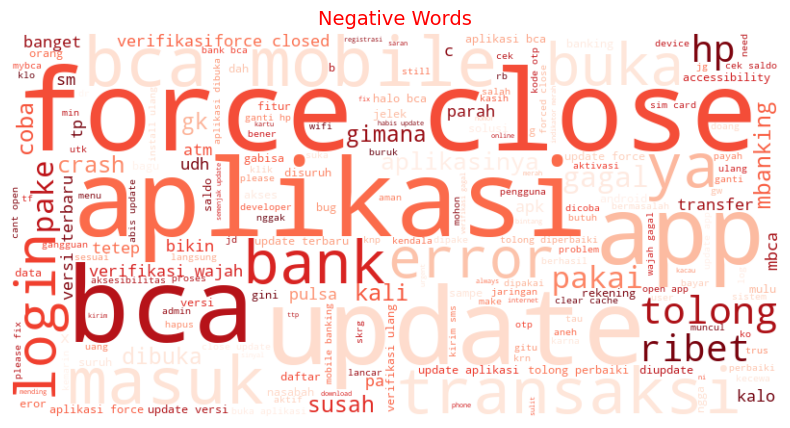

In [31]:
from wordcloud import WordCloud

Negative_text = " ".join(bca[bca["sentiment"]== 0]["processedwords"].dropna().apply(lambda x:" ".join(x)))

wordcloud_negatives = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(Negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_negatives, interpolation="bilinear")
plt.title("Negative Words", fontsize=14, color="red")
plt.axis("off")
plt.show()

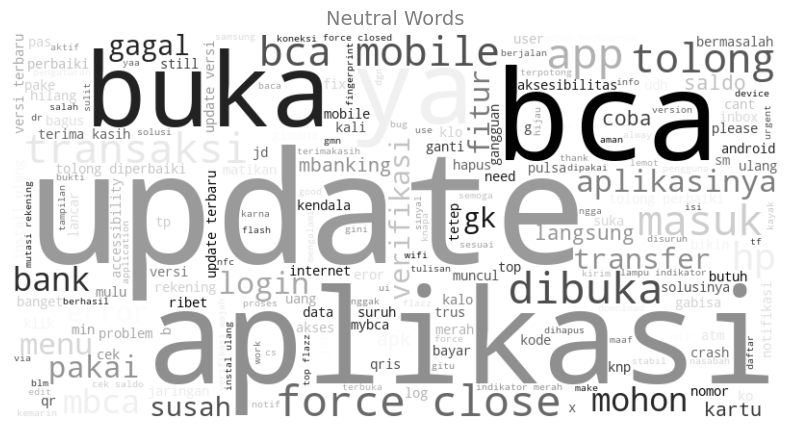

In [32]:
from wordcloud import WordCloud

Neutral_text = " ".join(bca[bca["sentiment"]== 1]["processedwords"].dropna().apply(lambda x:" ".join(x)))

wordcloud_neutrals = WordCloud(width=800, height=400, background_color="white", colormap="gray").generate(Neutral_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neutrals, interpolation="bilinear")
plt.title("Neutral Words", fontsize=14, color="gray")
plt.axis("off")
plt.show()

#### More Visualization 😁 3

<function matplotlib.pyplot.show(close=None, block=None)>

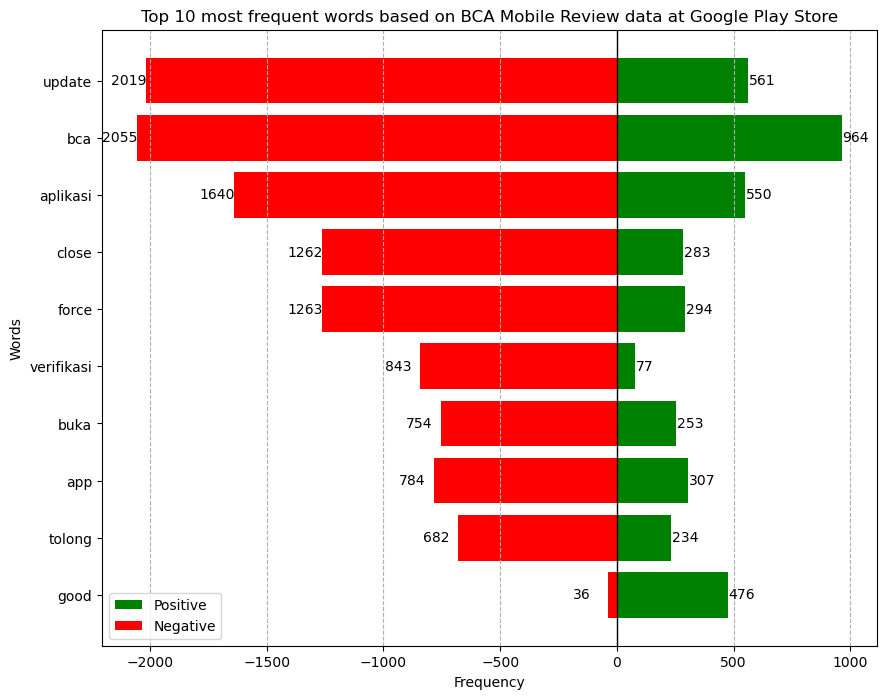

In [13]:
from collections import Counter

# calculate word frequencies for each sentiment
positive_words = bca[bca["sentiment"] == 2]['processedwords']
negative_words = bca[bca["sentiment"] == 0]['processedwords']
neutral_words = bca[bca["sentiment"] == 1]['processedwords']

positive_frequen = Counter([word for words in positive_words for word in words])
negative_frequen = Counter([word for words in negative_words for word in words])
neutral_words_frequen = Counter([word for words in neutral_words  for word in words])

# Get top 10 words from each sentiment
top_n = 10
top_positive = [word for word, _ in positive_frequen.most_common(top_n)]
top_negative = [word for word, _ in negative_frequen.most_common(top_n)]

#combine words and create DataFrame
combined_words = list(set(top_positive+top_negative)) #merging
bca_combined = pd.DataFrame({'word':combined_words})
bca_combined['positive'] = bca_combined['word'].apply(lambda x: positive_frequen.get(x,0 ))
bca_combined['negative'] = bca_combined['word'].apply(lambda x: negative_frequen.get(x,0))

# Calculate absolute difference and Sort by importance
bca_combined['diff'] = abs(bca_combined['positive'] - bca_combined['negative'])
bca_sorted = bca_combined.nlargest(10, 'diff').sort_values('diff', ascending=True)

#Plot the visualization
plt.figure(figsize=(10,8))
positive_bar = plt.barh(bca_sorted['word'], bca_sorted['positive'], color='green', label='Positive')
negative_bar = plt.barh(bca_sorted['word'], -bca_sorted['negative'], color='red', label='Negative') # -bca sorted for minus negative

for bar in positive_bar:
    plt.text(bar.get_width() + 3, bar.get_y() + bar.get_height()/2, #adjust position
                str(int(bar.get_width())), va="center", fontsize=10, color="black")
    
for bar in negative_bar:
    plt.text(bar.get_width() - 150, bar.get_y() + bar.get_height()/2, #adjust position
                str(abs(int(bar.get_width()))), va="center", fontsize=10, color="black")

plt.axvline(x=0, color='black', linewidth=1) #Add vertical line at 0

# Set max width for centering
plt.xlabel('Frequency')
plt.ylabel("Words")
plt.title('Top 10 most frequent words based on BCA Mobile Review data at Google Play Store')
plt.legend()
plt.grid(axis='x', linestyle='--')
plt.show

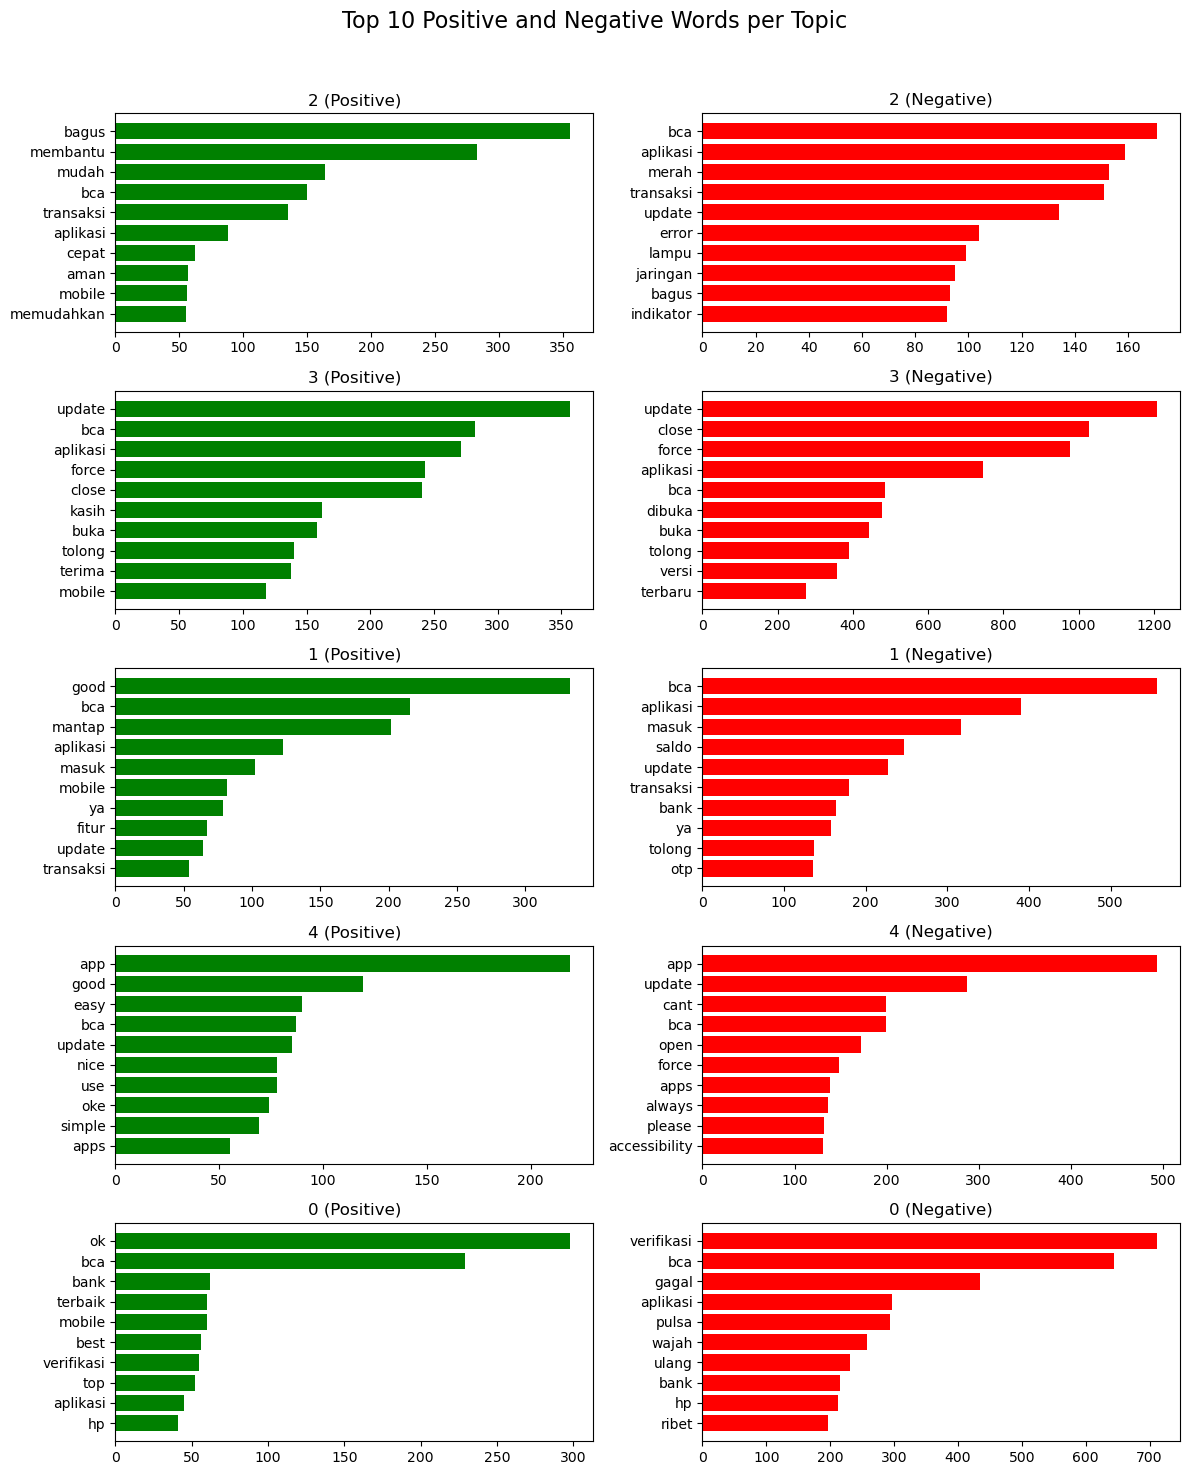

In [33]:
# Reinitialize dictionary to store words per topic and sentiment
word_counts = {topic: {"positive": Counter(), "negative": Counter()} for topic in topic_mapping.values()}

# Assign topics and count words per sentiment
for i, doc in enumerate(topic_counts):
    if i < len(bca):  # Ensure index is within range
        main_topic = max(doc, key=lambda x: x[1])[0]  # Get most relevant topic
        mapped_topic = topic_mapping[main_topic]  # Map to predefined label
        sentiment = int(bca.iloc[i]["sentiment"])
        
        if sentiment in [0, 2]:  # Only negative (0) and positive (2)
            sentiment_label = "positive" if sentiment == 2 else "negative"
            words = bca.iloc[i]["processedwords"]  # Use preprocessed words
            word_counts[mapped_topic][sentiment_label].update(words)

# Visualization of top words per topic and sentiment
fig, axes = plt.subplots(len(topic_mapping), 2, figsize=(12, 15))
fig.suptitle("Top 10 Positive and Negative Words per Topic", fontsize=16)

for i, (topic, sentiments) in enumerate(word_counts.items()):
    for j, sentiment in enumerate(["positive", "negative"]):
        top_words = sentiments[sentiment].most_common(10)
        words, counts = zip(*top_words) if top_words else ([], [])
        
        ax = axes[i, j]
        ax.barh(words, counts, color="green" if sentiment == "positive" else "red")
        ax.set_title(f"{topic} ({sentiment.capitalize()})")
        ax.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

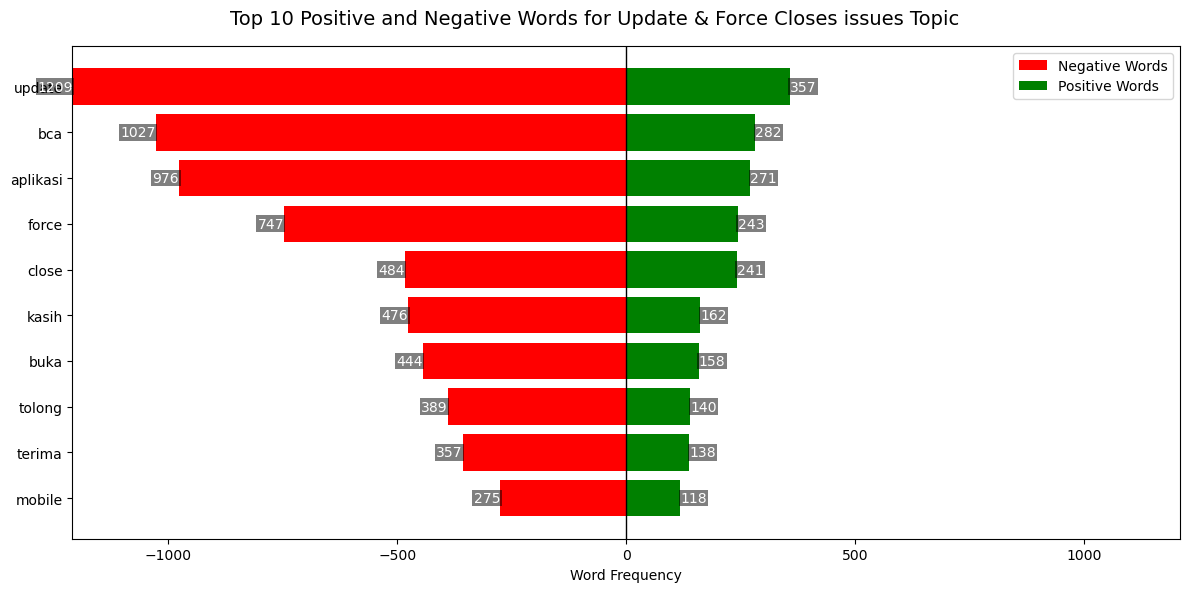

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Define the topic name we want to visualize
selected_topic_name = "Update & Force Closes issues"

# Find the correct topic index from the mapping
mapped_index = None
for key, value in topic_mapping.items():
    if value == 4:  # "Update & Force Closes issues" is mapped to index 3
        mapped_index = key
        break

if mapped_index is not None and mapped_index in word_counts:
    sentiments = word_counts[mapped_index]  # Get word counts for the correct topic

    if "positive" in sentiments and "negative" in sentiments:
        # Get top words for positive and negative sentiment
        top_positive = sentiments["positive"].most_common(10)
        top_negative = sentiments["negative"].most_common(10)

        # Extract words and counts
        positive_words, positive_counts = zip(*top_positive) if top_positive else ([], [])
        negative_words, negative_counts = zip(*top_negative) if top_negative else ([], [])

        # Ensure equal length by padding with zeros (if necessary)
        max_len = max(len(positive_words), len(negative_words))
        positive_words += ("",) * (max_len - len(positive_words))
        negative_words += ("",) * (max_len - len(negative_words))
        positive_counts += (0,) * (max_len - len(positive_counts))
        negative_counts += (0,) * (max_len - len(negative_counts))

        # Reverse order for better visualization
        positive_words = positive_words[::-1]
        negative_words = negative_words[::-1]
        positive_counts = positive_counts[::-1]
        negative_counts = negative_counts[::-1]

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))
        fig.suptitle(f"Top 10 Positive and Negative Words for {selected_topic_name} Topic", fontsize=14)

        # Define y-axis positions
        y_pos = np.arange(max_len)

        # Set max width for centering
        max_count = max(max(positive_counts, default=0), max(negative_counts, default=0))

        # Plot bars with centering
        ax.barh(y_pos, [-val for val in negative_counts], color="red", label="Negative Words", align="center")
        ax.barh(y_pos, positive_counts, color="green", label="Positive Words", align="center")

        # Set labels and titles
        ax.set_yticks(y_pos)
        ax.set_yticklabels(positive_words)  # Display words on the left side
        ax.set_xlabel("Word Frequency")
        ax.set_xlim(-max_count, max_count)  # Ensure both sides are symmetric
        ax.axvline(0, color="black", linewidth=1)  # Vertical center line at 0
        ax.legend(loc="upper right")

        # Add labels on bars
        for i, (neg, pos) in enumerate(zip(negative_counts, positive_counts)):
            if neg > 0:
                ax.text(-neg, y_pos[i], f"{neg}", ha="right", va="center", color="white",
                        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none", pad=1))
            if pos > 0:
                ax.text(pos, y_pos[i], f"{pos}", ha="left", va="center", color="white",
                        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none", pad=1))

        # plt.gca().invert_yaxis()  # Invert to keep the highest frequency at the top
        plt.tight_layout()
        plt.show()
    else:
        print(f"No sentiment data found for topic {selected_topic_name}.")
else:
    print(f"Topic '{selected_topic_name}' not found in word_counts or mapping.")
